In [5]:
import os
import numpy as np
from keras.src.saving.saving_api import load_model
from keras import backend as K
from keras.src.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.src.utils.numerical_utils import to_categorical
from PIL import Image
import tensorflow as tf
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import torch
import transformers

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tải mô hình và dữ liệu cần thiết

In [6]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',      
            2:'Speed limit (50km/h)',       
            3:'Speed limit (60km/h)',      
            4:'Speed limit (70km/h)',    
            5:'Speed limit (80km/h)',      
            6:'End of speed limit (80km/h)',     
            7:'Speed limit (100km/h)',    
            8:'Speed limit (120km/h)',     
            9:'No passing',   
            10:'No passing veh over 3.5 tons',     
            11:'Right-of-way at intersection',     
            12:'Priority road',    
            13:'Yield',     
            14:'Stop',       
            15:'No vehicles',       
            16:'Veh > 3.5 tons prohibited',       
            17:'No entry',       
            18:'General caution',     
            19:'Dangerous curve left',      
            20:'Dangerous curve right',   
            21:'Double curve',      
            22:'Bumpy road',     
            23:'Slippery road',       
            24:'Road narrows on the right',  
            25:'Road work',    
            26:'Traffic signals',      
            27:'Pedestrians',     
            28:'Children crossing',     
            29:'Bicycles crossing',       
            30:'Beware of ice/snow',
            31:'Wild animals crossing',      
            32:'End speed + passing limits',      
            33:'Turn right ahead',     
            34:'Turn left ahead',       
            35:'Ahead only',      
            36:'Go straight or right',      
            37:'Go straight or left',      
            38:'Keep right',     
            39:'Keep left',      
            40:'Roundabout mandatory',     
            41:'End of no passing',      
            42:'End no passing veh > 3.5 tons' }


In [7]:
# Đọc dữ liệu từ file test.csv và tiền xử lý
def load_data_from_csv(csv_file):
    data = []
    labels = []
    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        for line in lines:
            parts = line.strip().split(',')
            image_path = parts[-1]
            try:
                image = Image.open(image_path)
                image = image.resize((30, 30))
                image = np.array(image)
                data.append(image)
                labels.append(int(parts[-2]))  # ClassId là phần thứ 7 từ cuối dòng
            except Exception as e:
                print(f"Error loading image: {e}")
    return np.array(data), np.array(labels)

In [8]:
# Load dữ liệu huấn luyện
X_train, y_train = load_data_from_csv("Train.csv")

In [9]:
# Load dữ liệu thử nghiệm
X_test, y_test = load_data_from_csv("test.csv")

In [10]:
# Load mô hình đã được lưu
model = load_model("my_model.h5")

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Hàm tạo nhiễu One pixel attack

In [11]:
def one_pixel_attack(image, model, num_pixels=1, max_iters=100, step_size=1.0):
    perturbed_image = np.copy(image)
    for _ in range(num_pixels):
        # Tìm kiếm gradient cho việc thêm một pixel vào ảnh
        gradient = np.zeros_like(image)
        best_pixel = None
        best_loss = float('inf')
        for _ in range(max_iters):
            pixel_x, pixel_y = np.random.randint(0, image.shape[0]), np.random.randint(0, image.shape[1])
            # Thêm một pixel vào ảnh
            perturbed_image[pixel_x, pixel_y] = np.random.uniform(0, 255)
            # Tính loss
            loss = -model.predict(np.expand_dims(perturbed_image, axis=0))[0, np.argmax(model.predict(np.expand_dims(image, axis=0)))]
            # Lưu trữ pixel tốt nhất cho việc thêm vào
            if loss < best_loss:
                best_loss = loss
                best_pixel = (pixel_x, pixel_y)
            # Đặt lại ảnh về trạng thái ban đầu
            perturbed_image[pixel_x, pixel_y] = image[pixel_x, pixel_y]
        # Thêm pixel tốt nhất vào ảnh
        perturbed_image[best_pixel[0], best_pixel[1]] = np.random.uniform(0, 255)
    return perturbed_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

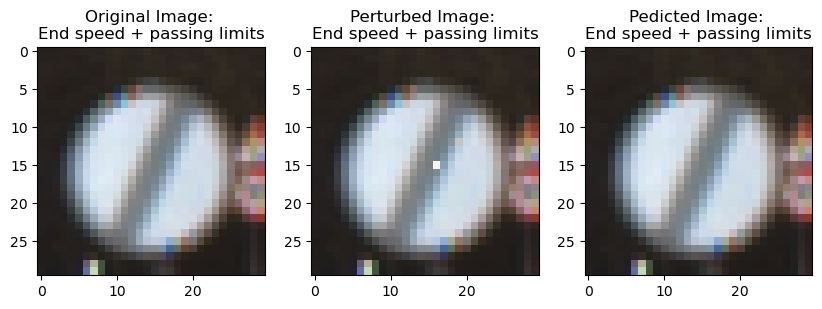

In [36]:
i = np.random.randint(0, 12600)

# Sử dụng hàm one_pixel_attack với gradient descent để tạo ra ảnh tấn công
num_pixels = 2
perturbed_one_pixel = one_pixel_attack(X_test[i], model, num_pixels=num_pixels)
original_label = y_test[i]

# Hiển thị ảnh trước và sau khi bị tấn công cùng với nhãn
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_test[i])
plt.title(f"Original Image: \n{classes[original_label]}")

plt.subplot(1, 3, 3)
plt.imshow(X_test[i])
plt.title(f"Pedicted Image: \n{classes[np.argmax(model.predict(X_test[i:i+1]))]}")

plt.subplot(1, 3, 2)
plt.imshow(perturbed_one_pixel)
plt.title(f"Perturbed Image: \n{classes[np.argmax(model.predict(np.expand_dims(perturbed_one_pixel, axis=0)))]}")

plt.show()


# Tạo nhiễu trên 1 tập train và lưu ảnh nhiễu

In [ ]:
# # Create directory for adversarial images if it doesn't exist
# adv_train_dir = '1px_atk_train'
# if not os.path.exists(adv_train_dir):
#     os.makedirs(adv_train_dir)

In [ ]:
# num_pixels = 2
# # Generate adversarial examples using one_pixel_attack for the first 2430 images in the training set
# for i, img in enumerate(X_train[:2430]):
#     perturbed_img = one_pixel_attack(img, model, num_pixels=num_pixels)
#     # Save the perturbed image
#     adv_img = Image.fromarray(perturbed_img.astype(np.uint8))
#     adv_img.save(os.path.join(adv_train_dir, f"adv_img_{i}.png"))

In [24]:
# Đọc các ảnh nhiễu
def load_1px_per_data():
    data = []
    for i in range(279):
        image_path = f'1px_atk_train/adv_img_{i}.png'
        try:
            image = Image.open(image_path)
            image = image.resize((30, 30))
            image = np.array(image)
            data.append(image)
        except Exception as e:
            print(f"Error loading image: {e}")
    return np.array(data)

In [25]:
X_per = load_1px_per_data()
y_per = 20

# Tỷ lệ accuracy trên tập ảnh nhiễu

In [26]:
y_pred = model.predict(X_per)
y_pred_per_classes = np.argmax(y_pred, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [27]:
y_pred = model.predict(X_train[:279])
y_pred_classes = np.argmax(y_pred, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [28]:
accuracy = accuracy_score(y_pred_classes, y_train[:279])
print(f"Accuracy trước khi thêm nhiễu: {accuracy}")
accuracy = accuracy_score(y_pred_per_classes, y_train[:279])
print(f"Accuracy sau khi thêm nhiễu: {accuracy}")

Accuracy trước khi thêm nhiễu: 0.910394265232975


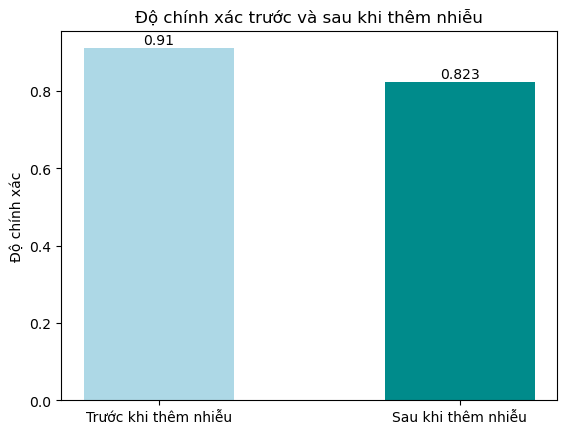

In [56]:
import matplotlib.pyplot as plt

accuracy_before = 0.910
accuracy_after = 0.823
accuracies = [accuracy_before, accuracy_after]
labels = ['Trước khi thêm nhiễu', 'Sau khi thêm nhiễu']
plt.bar(labels, accuracies, color=['lightblue', 'darkcyan'], width=0.5)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, str(v), ha='center')
plt.title('Độ chính xác trước và sau khi thêm nhiễu')
plt.ylabel('Độ chính xác')
plt.show()